In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import xgboost as xgb
from matplotlib.colors import LinearSegmentedColormap
import requests
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from pygam import LinearGAM, s, f
import sklearn
from joblib import dump, load
from sklearn.linear_model import LinearRegression

In [3]:
dengue_df = pd.read_csv(r'C:\Users\Mrman\pypboi\Dengue_temp_prec_pop.csv')

In [4]:
Q1 = dengue_df['Annual_dengue_total'].quantile(0.25)
Q3 = dengue_df['Annual_dengue_total'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + IQR

# Filter countries that are endemic for dengue fever
endemic_countries_df = dengue_df[dengue_df['Annual_dengue_total'] > upper_bound]

In [5]:
print(endemic_countries_df.head())

        Country Code  Year  Annual_dengue_total Country_temp   Avg_Temp  \
49    Argentina  ARG  2009              26612.0    Argentina  15.081761   
56    Argentina  ARG  2016              78034.0    Argentina  14.622075   
60    Argentina  ARG  2020              59290.0    Argentina  15.251497   
146  Bangladesh  BGD  2019             104954.0   Bangladesh  25.765463   
148  Bangladesh  BGD  2021              26683.0   Bangladesh  25.842774   

    Country_prec  Annual_precipitation Country_pop   Population  
49     Argentina              675.8896   Argentina   40854831.0  
56     Argentina              804.3934   Argentina   43900313.0  
60     Argentina              578.3959   Argentina   45191965.0  
146   Bangladesh             1995.7064  Bangladesh  164913055.0  
148   Bangladesh             1985.9770  Bangladesh  167658854.0  


In [6]:
print(endemic_countries_df.dtypes)

Country                  object
Code                     object
Year                      int64
Annual_dengue_total     float64
Country_temp             object
Avg_Temp                float64
Country_prec             object
Annual_precipitation    float64
Country_pop              object
Population              float64
dtype: object


In [7]:
print(endemic_countries_df.isnull().sum())

Country                 0
Code                    0
Year                    0
Annual_dengue_total     0
Country_temp            0
Avg_Temp                0
Country_prec            0
Annual_precipitation    0
Country_pop             0
Population              0
dtype: int64


In [8]:
endemic_countries_df['Count_per_100k'] = (endemic_countries_df['Annual_dengue_total'] / endemic_countries_df['Population']) * 100000

endemic_countries_df['log_cases_per_100k'] = np.log1p(endemic_countries_df['Count_per_100k'])  # log1p avoids issues with zeros
endemic_countries_df['log_population'] = np.log1p(endemic_countries_df['Population'])
endemic_countries_df['log_precipitation'] = np.log1p(endemic_countries_df['Annual_precipitation'])
endemic_countries_df['temperature_squared'] = endemic_countries_df['Avg_Temp'] ** 2
endemic_countries_df['log_total_cases'] = np.log1p(endemic_countries_df['Annual_dengue_total'])

C:\Users\Mrman\AppData\Local\Temp1\ipykernel_62528\1937052013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endemic_countries_df['Count_per_100k'] = (endemic_countries_df['Annual_dengue_total'] / endemic_countries_df['Population']) * 100000
C:\Users\Mrman\AppData\Local\Temp1\ipykernel_62528\1937052013.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endemic_countries_df['log_cases_per_100k'] = np.log1p(endemic_countries_df['Count_per_100k'])  # log1p avoids issues with zeros
C:\Users\Mrman\AppData\

In [16]:
# assign x and y variables
X = endemic_countries_df[['temperature_squared', 'Annual_precipitation', 'Population']] #predictor
X_nopop = endemic_countries_df[['Avg_Temp', 'Annual_precipitation']] #predictor without population
y = endemic_countries_df['log_cases_per_100k'] #target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# training data without population
X_train_nopop, X_test_nopop, y_train_nopop, y_test_nopop = train_test_split(X_nopop, y, test_size=0.2, random_state=42)

In [17]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = linear_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MSE: 1.353
R²: 0.336


In [18]:
# Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 5],
    'max_features': ['sqrt', 'log2'],
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid, 
                      cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)

# Get the best model and evaluate it
rf_best_model = rf_grid.best_estimator_
rf_y_pred = rf_best_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

print(f"Best Random Forest parameters: {rf_grid.best_params_}")
print(f"Best Random Forest MSE: {rf_mse}")
print(f"Best Random Forest R²: {rf_r2}")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Random Forest parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Random Forest MSE: 0.5073235373145532
Best Random Forest R²: 0.750888068608003


In [19]:
print(f"Variance of y_test: {y_test.var()}")

Variance of y_test: 2.0693756904079628


## Training Random Forest Model

In [20]:
rf_model_dengue = RandomForestRegressor(
    n_estimators=300,  # Number of trees
    max_depth=None,    # Maximum depth of trees (None means unlimited)
    min_samples_split=2,  # Minimum samples required to split a node
    min_samples_leaf=1,   # Minimum samples required at each leaf node
    max_features='sqrt',  # Number of features to consider for best split
    random_state=42       # For reproducibility
)

# Train the model
rf_model_dengue.fit(X_train, y_train)

# Make predictions
y_pred_train = rf_model_dengue.predict(X_train)
y_pred_test = rf_model_dengue.predict(X_test)

In [21]:
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Training MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")
print(f"Training R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")

Training MSE: 0.118
Test MSE: 0.507
Training R²: 0.934
Test R²: 0.751


In [22]:
# Save the Random Forest model to a file
dump(rf_model_dengue, "dengue_randomforest_model.joblib")

['dengue_randomforest_model.joblib']

## Model Evaluation

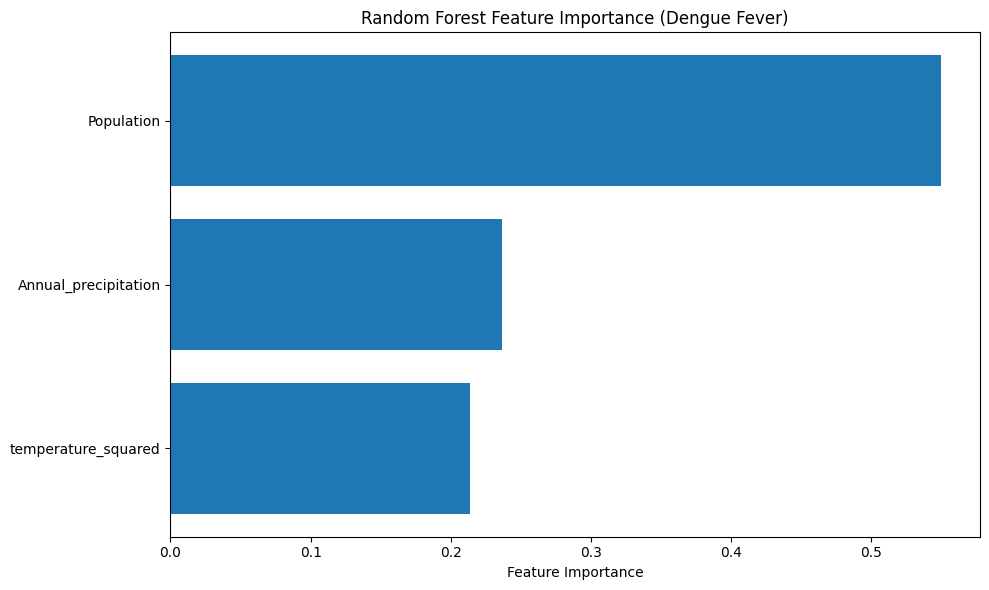

In [23]:
# Feature importance
feature_importance = rf_model_dengue.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (Dengue Fever)')
plt.tight_layout()
plt.show()

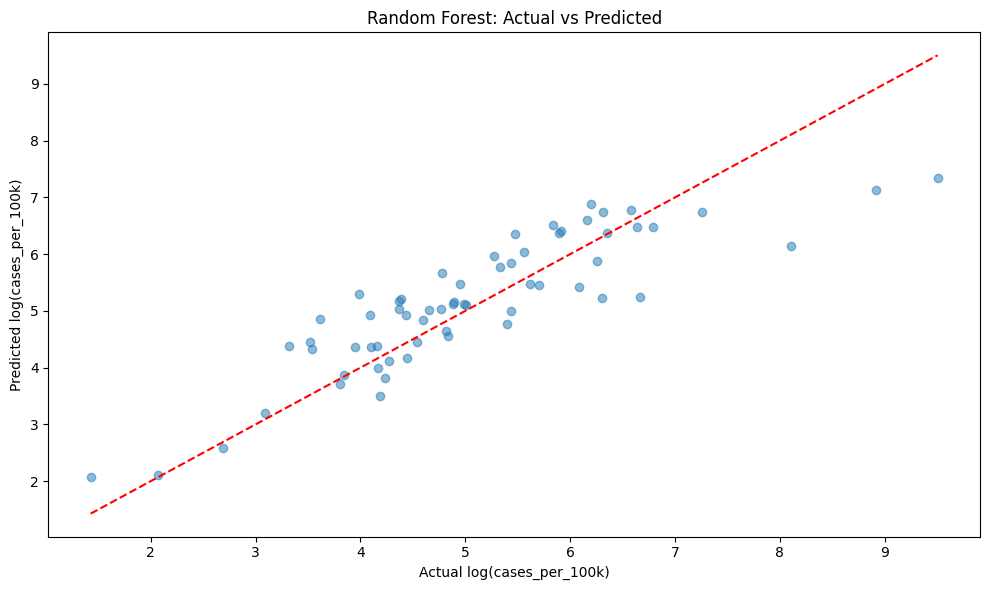

In [203]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual log(cases_per_100k)')
plt.ylabel('Predicted log(cases_per_100k)')
plt.title('Random Forest: Actual vs Predicted')
plt.tight_layout()
plt.show()

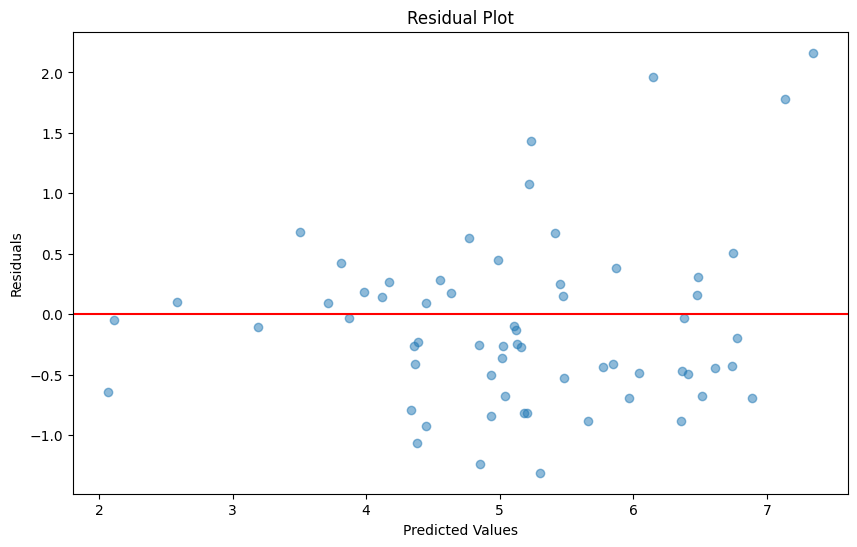

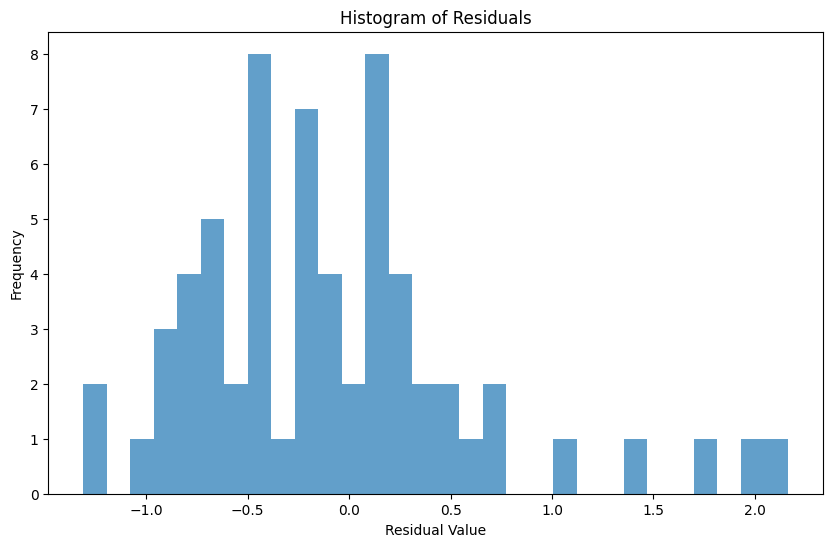

In [204]:
# Calculate residuals
dengue_residuals = y_test - y_pred_test

# Plot residuals vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, dengue_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(dengue_residuals, bins=30, alpha=0.7)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

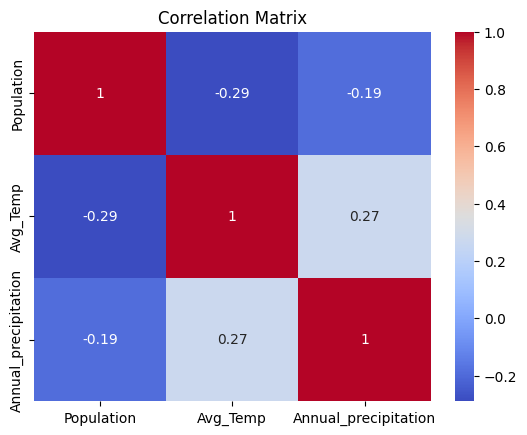

In [205]:

corr = endemic_countries_df[['Population', 'Avg_Temp', 'Annual_precipitation']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

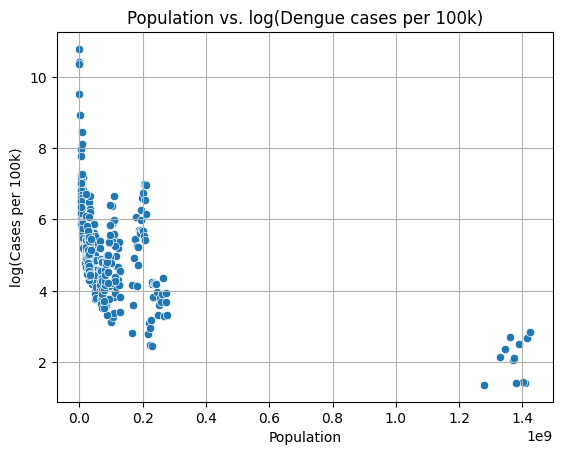

In [206]:
sns.scatterplot(x='Population', y='log_cases_per_100k', data=endemic_countries_df)
plt.title("Population vs. log(Dengue cases per 100k)")
plt.xlabel("Population")
plt.ylabel("log(Cases per 100k)")
plt.grid(True)
plt.show()
